#Bayesian approach with `emcee` - Lees Ferry - 4 free parameters (and an additional constraint on time-integrated erosion)

Application of the Bayesian approach with 4 free parameters (erosion rate, time exposure, density and inheritance) to the Lees Ferry M4y sand-deposit terrace site (see [Hidy et al. 2010](http://onlinelibrary.wiley.com/doi/10.1029/2010GC003084/abstract)), using the [emcee](http://dan.iel.fm/emcee/current/) package.

We also define here an additional constraint on the total erosion (erosion rate integrated over the time exposure).

For more info about the method used, see the notebook [Inference_Notes](Inference_Notes.ipynb).

This notebook has the following external dependencies:

In [1]:
import math
import csv

import numpy as np
import pandas as pd
from scipy import stats
from scipy import optimize
import emcee
import yaml

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
clr_plt = sns.color_palette()

## The mathematical (deterministic, forward) model

An implementation of the mathematical model used for predicting profiles of 10Be concentrations is available in the `models` Python module (see the notebook [Models](Models.ipynb)). The 10Be model assumes that the soil density is constant along the depth profile and that the inheritance is the same for the whole sample of 10Be concentration vs. depth.

In [2]:
import models

## The data


In [3]:
profile_data = pd.read_csv('profiles_data/lees_ferry_m4y_sand_10Be_profile.csv',
                           index_col='sample',
                           delim_whitespace=True,
                           comment='#',
                           quoting=csv.QUOTE_NONNUMERIC, quotechar='\"',
                           na_values=[-9999],
                           dtype={'depth': 'f', 'depth_g-cm-2': 'f',
                                  'C': 'f', 'std': 'f'})

profile_data

,depth,depth_g-cm-2,C,std,nuclide
sample,,,,,
s01,27.5,NaN,568744,17347,10Be
s02,57.5,NaN,406713,11469,10Be
s03,97.5,NaN,292243,8972,10Be
s04,137.5,NaN,203072,6234,10Be
s05,177.5,NaN,157209,4921,10Be
s06,217.5,NaN,134198,3892,10Be


Import other parameters

In [4]:
with open('profiles_data/lees_ferry_m4y_sand_10Be_settings.yaml') as f:
    ferry_settings = yaml.load(f)

ferry_settings   

{'P_0': 9.51, 'altitude': 985.0, 'latitude': 36.852, 'pressure': 995.004}

Make a plot of the dataset

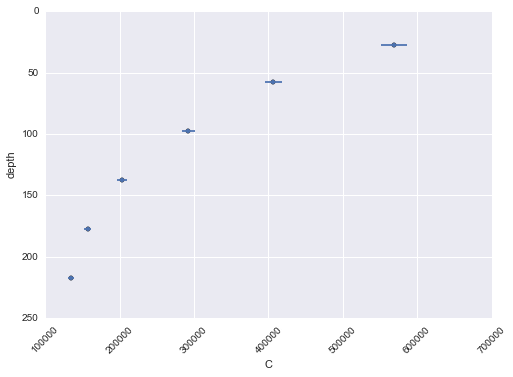

In [5]:
sns.set_context('notebook')

fig, ax = plt.subplots()

profile_data.plot(
    y='depth', x='C', xerr='std',
    kind="scatter", ax=ax, rot=45
)

ax.invert_yaxis()

## The statistical model used for computing the *posterior probability density* PPD

Here below we define a data model by the tuple `m = (eps, t, rho, inh)`. It correspond to a given location in the 4-d parameter space.

- Define the parameter names. It is important to use the same order to further define the `priors` and `bounds` tuples!

In [6]:
param_names = ('erosion rate', 'time exposure',
               'soil density', 'inheritance')

- Define the prior probability distribution for each free parameter. Here the uniform distribution is used, with given bounds (`loc` and `scale` arguments of `scipy.stats.uniform` are the lower bound and the range, respectively)

In [7]:
eps_prior = stats.uniform(loc=0., scale=1e-3)
t_prior = stats.uniform(loc=0., scale=4e5)
rho_prior = stats.uniform(loc=2.2, scale=0.3)
inh_prior = stats.uniform(loc=0., scale=1.5e5)

priors = eps_prior, t_prior, rho_prior, inh_prior
param_priors = pd.Series(priors, index=param_names)

- Define (min, max) bounds for each free parameter. It should be given by lower and upper quantiles (`lower_qtl`, `upper_qtl`) of the prior distribution. Choose the extreme quantiles (0, 1) if the distribution is uniform. It will be used for plotting purpose and also for constrained optimization (see below).

In [8]:
def get_bounds(f, lower_qtl=0., upper_qtl=1.):
    return f.ppf(lower_qtl), f.ppf(upper_qtl)

eps_bounds = get_bounds(eps_prior, 0, 1)
t_bounds = get_bounds(t_prior, 0, 1)
rho_bounds = get_bounds(rho_prior, 0, 1)
inh_bounds = get_bounds(inh_prior, 0, 1)

bounds = eps_bounds, t_bounds, rho_bounds, inh_bounds
param_bounds = pd.DataFrame(
    np.array(bounds), columns=('min', 'max'), index=param_names
)

param_bounds

,min,max
erosion rate,0.0,0.001
time exposure,0.0,400000.000
soil density,2.2,2.500
inheritance,0.0,150000.000


- Plot the prior probability density for each parameter.

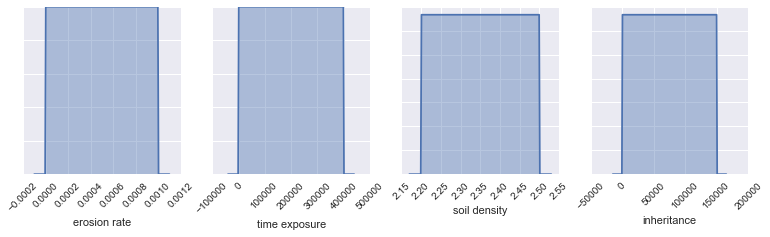

In [9]:
fig, axes = plt.subplots(1, 4, figsize=(13, 3))

for ax, p, b, name in zip(axes.flatten(),
                          param_priors.values,
                          param_bounds.values,
                          param_names):
    xmin, xmax = b
    eps = 0.1 * (xmax - xmin)
    x = np.linspace(xmin - eps, xmax + eps, 200)
    d = p.pdf(x)
    ax.plot(x, d)
    ax.fill(x, d, alpha=0.4)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
    plt.setp(ax, ylim=(0, None), yticklabels=[],
             xlabel=name)

plt.subplots_adjust()

- Define a function that returns the (logarithm of the) prior probability density for a given data model `m`.

In [27]:
def lnprior(m):
    lps = [p.logpdf(v) for (p, v) in zip(priors, m)]
    if not np.all(np.isfinite(lps)):
        return -np.inf
    return np.sum(lps)

- Define here the additional constraints which accept a data model $m$ as argument. It should return a log(probability).

In [28]:
def lnaddconst(m):
    eps, t, rho, inh = m
    
    # net erosion must be <= 30 cm
    if eps * t > 30:
        return -np.inf
    
    return 0

- Define a function that returns the log-likelihood. It is a $n$-dimensional Gaussian ($n$ nucleide concentrations sampled along the depth profile) with the mean given by the formard model and the variance given by the error estimated from the measurements of the nucleide concentration of each sample. This Gaussian implies that (1) the error on each measurement is random, (2) the sampled nucleide concentrations are measured independently of each other, (3) the forward model - i.e., the deterministic model that predicts the nucleide concentration profile - represents the real physics and (4) the values of the non-free parameters of the forward model - e.g., nucleide surface production rate, attenuation lengths... - are exactly known. **We also include here the additional constraints**.

In [32]:
def lnlike(m):
    eps, t, rho, inh = m
    
    mean = models.C_10Be(profile_data['depth'].values,
                         eps, t, rho, inh,
                         P_0=ferry_settings['P_0'])
    var = profile_data['std']**2
    
    lngauss = -0.5 * np.sum(
        np.log(2. * np.pi * var) +
        (profile_data['C'] - mean)**2 / var
    )   
    
    return lngauss + lnaddconst(m)

- Define a function that returns the log-posterior probability density, according to the Bayes's theorem.

In [33]:
def lnprob(m):
    lp = lnprior(m)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(m)

## Sampling the posterior probablility density using MCMC

In our case, the from of the PPD may be highly anisotropic ; it may present high (negative or positive) correlations between its parameters (erosion rate, exposure time, soil density, inheritance). Usually, these relationships are even non-linear.

It is therefore important to use a robust algorithm to sample this complex PPD. The Affine Invariant Markov chain Monte Carlo (MCMC) Ensemble sampler implemented in the [emcee](http://dan.iel.fm/emcee/current/) package will be more efficient in our case than the standard MCMC algorithms such as the Metropolis-Hasting method.

The `emcee` sampler allows to define multiple, independent *walkers*. This requires to first set the initial position of each walker in the parameter space. As shown in the `emcee` documentation, the author suggests initializing the walkers in a tiny Gaussian ball around the maximum likelihood result. We can obtain the maximum likelihood estimate by applying an optimization algorithm such as one of those implemented in the [scipy.optimize](http://docs.scipy.org/doc/scipy/reference/optimize.html) module. Note that non-linear optimization usually requires to provide an initial guess.

Given our complex, non-linear, and potentially flat form of the PDD in some areas of the parameter space, we prefer to set the initial positions of the walkers as the maximum likelihood estimates resulting from randomly chosing initial guesses in the parameter space according to the prior probability density. Note that we use a constrained optimization algorithm to ensure that the initial positions are within the bounds defined above. 

In [34]:
n_params, n_walkers = len(param_names), 100

# randomly choose initial guesses according to the prior
# and also according to the additional constraints
guesses = np.array(
    [p.rvs(size=n_walkers * 100) for p in priors]
).T
addconst_guesses = [lnaddconst(g) for g in guesses]
valid_guesses = guesses[np.isfinite(addconst_guesses)]
init_guesses = valid_guesses[0:n_walkers]

# perform non-linear optimization from each initial guess
op_lnlike = lambda *args: -lnlike(*args)
init_walkers = np.empty_like(init_guesses)

for i, g in enumerate(init_guesses):
    res = optimize.minimize(op_lnlike, g,
                            method='TNC',
                            bounds=bounds)
    init_walkers[i] = res['x']


We show below the initial guesses and the initial positions of the walkers in a scatter plot.

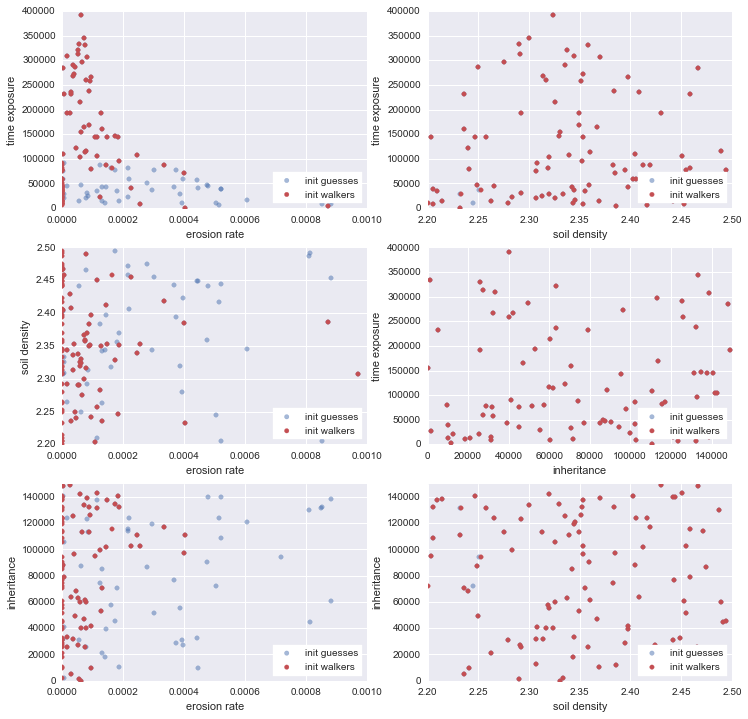

In [35]:
df_init_guesses = pd.DataFrame(init_guesses, columns=param_names)
df_init_walkers = pd.DataFrame(init_walkers, columns=param_names)

def scatter_pos(xcol, ycol, ax):
    df_init_guesses.plot(
        kind='scatter', x=xcol, y=ycol,
        alpha=0.5, ax=ax, color=clr_plt[0], label='init guesses'
    )
    df_init_walkers.plot(
        kind='scatter', x=xcol, y=ycol,
        alpha=1., ax=ax, color=clr_plt[2], label='init walkers'
    )
    legend = ax.legend(frameon=True, loc='lower right')
    legend.get_frame().set_facecolor('w')
    plt.setp(ax, xlim=param_bounds.loc[xcol],
             ylim=param_bounds.loc[ycol])

fig, ax = plt.subplots(3, 2, figsize=(12,12))
scatter_pos('erosion rate', 'time exposure', ax[0][0])
scatter_pos('soil density', 'time exposure', ax[0][1])
scatter_pos('erosion rate', 'soil density', ax[1][0])
scatter_pos('inheritance', 'time exposure', ax[1][1])
scatter_pos('erosion rate', 'inheritance', ax[2][0])
scatter_pos('soil density', 'inheritance', ax[2][1])

We can then setup the `emcee` sampler and run the MCMC for `n_steps` iterations starting from the initial positions defined above.

In [36]:
sampler = emcee.EnsembleSampler(n_walkers, n_params, lnprob)

n_steps = 500
sampler.run_mcmc(init_walkers, n_steps)

mcmc_samples = pd.DataFrame(sampler.flatchain,
                            columns=param_names)

Let's plot the trace of the MCMC iterations.

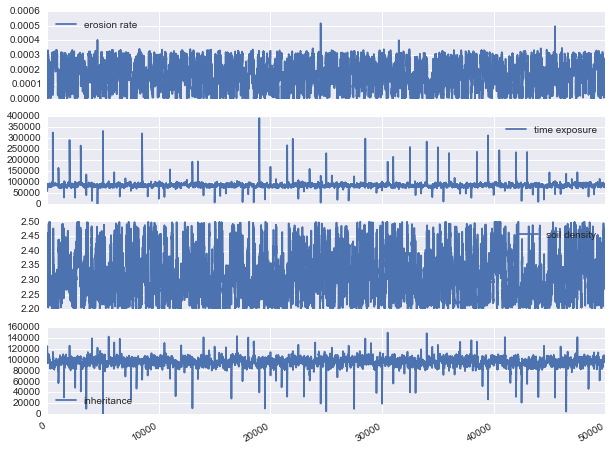

In [37]:
sample_plot_range = slice(None)

axes = mcmc_samples[sample_plot_range].plot(
    kind='line', subplots=True,
    figsize=(10, 8), color=clr_plt[0]
)

Try plotting only the firsts samples (e.g., `sample_range = slice(0, 1000)`). We see that thanks to the initial positions of the walkers, the `emcee` sampler quickly starts exploring the full posterior distribution. The “burn-in” period is small and we can therefore set a small value for `nburn` below.  

In [38]:
nburn = 100

mcmc_kept_samples = pd.DataFrame(
    sampler.chain[:, nburn:, :].reshape((-1, n_params)),
    columns=param_names
)

We can visualize the sampled posterior propbability density by joint plots of the MCMC samples.

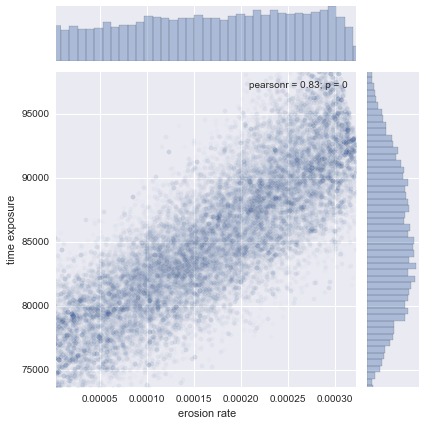

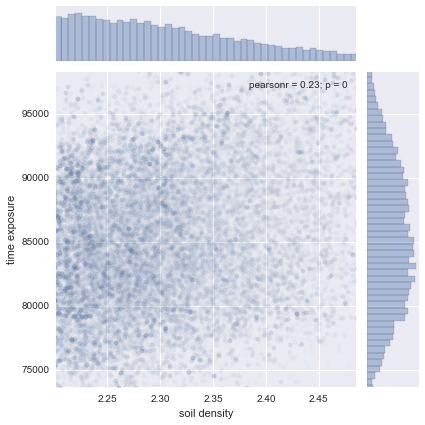

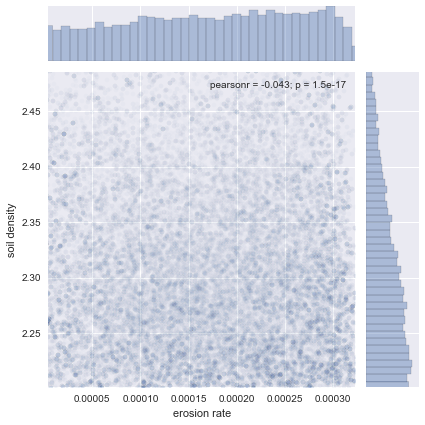

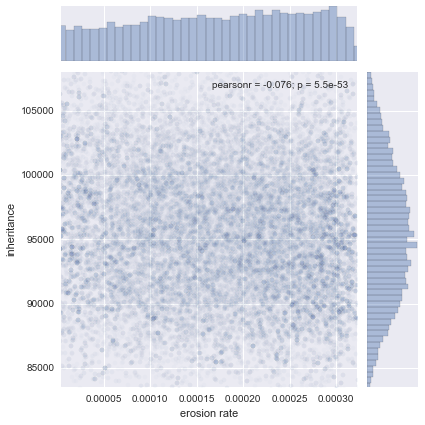

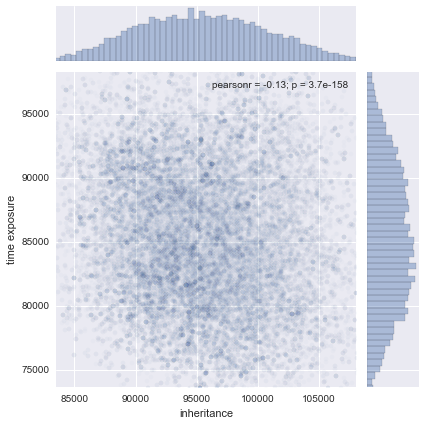

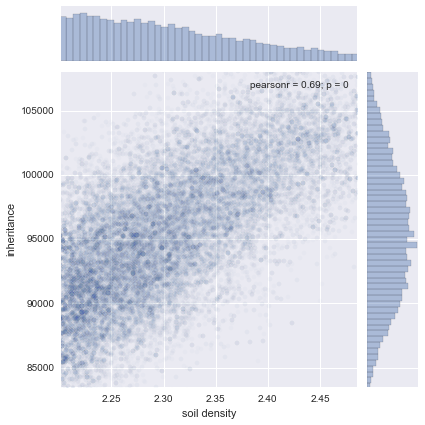

In [39]:
def jointplot_density(xcol, ycol, lim_qtl=(0.01, 0.99)):
    lower_qtl, upper_qtl = lim_qtl
    p = sns.jointplot(
        xcol, ycol,
        data=mcmc_kept_samples,
        xlim=(mcmc_kept_samples[xcol].quantile(lower_qtl),
              mcmc_kept_samples[xcol].quantile(upper_qtl)),
        ylim=(mcmc_kept_samples[ycol].quantile(lower_qtl),
              mcmc_kept_samples[ycol].quantile(upper_qtl)),
        joint_kws={'alpha': 0.02}
    )

jointplot_density('erosion rate', 'time exposure')
jointplot_density('soil density', 'time exposure')
jointplot_density('erosion rate', 'soil density')
jointplot_density('erosion rate', 'inheritance')
jointplot_density('inheritance', 'time exposure')
jointplot_density('soil density', 'inheritance')

Given the samples, it is straightforward to characterize the posterior porbability density and estimate its moments.

- the PPD mean (if the PPD distribution is strictly gaussian, it also correspond to the MAP (Maximum A-Posterori) and therefore the most probable model)

In [40]:
mcmc_kept_samples.mean()

erosion rate         0.000172
time exposure    85342.974090
soil density         2.305498
inheritance      95458.485813
dtype: float64

- the sample which have the max PPD value (i.e., the most probable sampled model)

In [41]:
max_ppd = sampler.lnprobability[:, nburn:].reshape((-1)).argmax()
mcmc_kept_samples.iloc[max_ppd]

erosion rate         0.000273
time exposure    88652.968674
soil density         2.200005
inheritance      89244.941638
Name: 33851, dtype: float64

- the PPD quantiles (useful for delineating the Bayesian confidence intervals or credible intervals for each free parameter)

In [42]:
percentiles = np.array([2.5, 5, 25, 50, 75, 95, 97.5])
mcmc_kept_samples.quantile(percentiles * 0.01)

,erosion rate,time exposure,soil density,inheritance
0.025,0.000010,75147.970965,2.204692,85401.154582
0.050,0.000021,76274.373036,2.209358,86820.750344
0.250,0.000099,80984.447252,2.243251,91476.627392
0.500,0.000177,85045.616750,2.292094,95333.320246
0.750,0.000251,89620.908722,2.356053,99292.223768
0.950,0.000306,94936.424355,2.448211,104565.722119
0.975,0.000315,96601.377775,2.467368,106152.556177


We finally plot the nucleide concentration profiles (blue dots: data w/ error bars, red area: filled interval between the 1% and 99% percentiles of the MCMC samples).

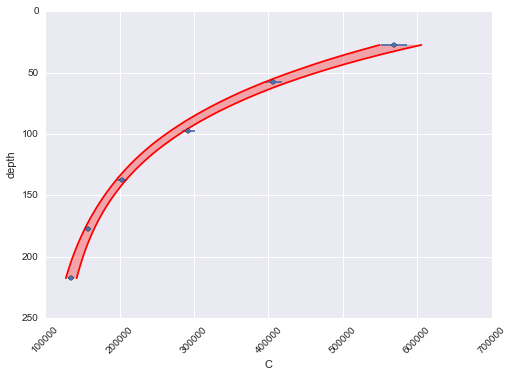

In [43]:
fig, ax = plt.subplots()

# plot MCMC samples 1-99 percentiles
depths = np.linspace(profile_data['depth'].min(),
                     profile_data['depth'].max(),
                     50)
c_mcmc_samples = np.array(
    [models.C_10Be(depths, eps, t, rho, inh,
                   P_0=ferry_settings['P_0'])
     for (eps, t, rho, inh) in mcmc_kept_samples.values]
)
c01, c99 = np.percentile(c_mcmc_samples, (1, 99), axis=0)

ax.fill_betweenx(depths, c01, c99, color='r', alpha=0.3)
ax.plot(c01, depths, color='r')
ax.plot(c99, depths, color='r')

# plot the profile data with error bars
profile_data.plot(
    y='depth', x='C', xerr='std',
    kind="scatter", ax=ax, rot=45, zorder=5
)

ax.invert_yaxis()

### Information about this notebook

Author: B. Bovy, [Ulg](http://www.ulg.ac.be)

<a href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons License" style="border-width:0" src="http://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>.
